In [1]:
ENV["JULIA_PKG_USE_CLI_GIT"] = "true"
cd("/leonardo_work/Sis25_degironc_0/apol/aceconverge2025/")
pwd()

import Pkg
Pkg.activate(".")
# Pkg.add(Pkg.PackageSpec(;name="ACEpotentials", version="0.6.7"))
using ACEpotentials, LinearAlgebra

  Activating project at `/leonardo_work/Sis25_degironc_0/apol/aceconverge2025`


# `trainmodel.jl` tester

In [3]:
train_data = read_extxyz("datasets/Tr100_n.xyz");

In [4]:
elossweight = 50.0
rcut = 5.0
pureflag = false

println("\nAssigning offset.")
Vref = OneBody(:C => -245.44385736) # one-body energy
println("Vref: ", Vref)
println("Assigning weights.")
weights = Dict("shaiducarbon" => Dict("E" => elossweight, "F" => 1.0))
println("Weights: ", weights)
datakeys = (energy_key = "energy", force_key = "force")
train_atoms = [ACEpotentials.AtomsData(t; weights=weights, v_ref=Vref, datakeys...) for t in train_data];


Assigning offset.
Vref: OneBody{Float64}(Dict(:C => -245.44385736))
Assigning weights.
Weights: Dict("shaiducarbon" => Dict("E" => 50.0, "F" => 1.0))


In [8]:
orders = [2,3]
# degrees = [[26,22],[26,22,18],[26,22,18,14]]
# basis_tags = ["26.22","26.22.18","26.22.18.14"]
degrees = [[16,12],[16,12,8]]
basis_tags = ["16.12","16.12.8"]
r0 = 1.286958464 # equilibrium length from dimer dataset
potlist = Dict()

for (i,label) in enumerate(basis_tags)
    for priorval in [1 3 5]
        println("\nCreating basis for order $(orders[i]), with per-correlation degrees $(degrees[i]) and algebraic prior of order $(priorval).")
        println("r0 = $r0, rcut = $rcut.")
        basis = ACE1x.ace_basis(
            elements = [:C],
            order = orders[i],
            totaldegree = degrees[i],
            rcut = rcut,
            r0 = r0,
            pure = pureflag)
        println("Basis for $label created, with $(length(basis)) basis functions.")

        println("Assembling linear problem elements: A, Y, W for basis set: $label.")
        A, Y, W = ACEfit.assemble(train_atoms, basis)
        println("Creating priors and modifying A.")
        P = smoothness_prior(basis; p=priorval)
        Ap = Diagonal(W) * (A/P)
        yp = Diagonal(W) * Y
        println("Solving linear problem.")
        results = ACEfit.solve(ACEfit.BLR(; verbose=true), Ap, yp)
        println("Assembling potential.")
        potlist[label*",P="*string(priorval)] = JuLIP.MLIPs.SumIP(Vref, JuLIP.MLIPs.combine(basis, results["C"]))
    end
end


Creating basis for order 2, with per-correlation degrees [16, 12] and algebraic prior of order 1.
r0 = 1.286958464, rcut = 5.0.
Basis for 16.12 created, with 83 basis functions.
Assembling linear problem elements: A, Y, W for basis set: 16.12.


[ Info: Assembling linear problem.
[ Info:   - Creating feature matrix with size (5476, 83).
[ Info:   - Beginning assembly with processor count:  1.
Progress: 100%|█████████████████████████████████████████| Time: 0:00:28


Creating priors and modifying A.
Solving linear problem.
Iter     Function value   Gradient norm 
     0     1.204286e+04     6.249257e+03
 * time: 5.888938903808594e-5


[ Info:   - Assembly completed.
[ Info: Assembling full weight vector.
┌ Warning: x_tol is deprecated. Use x_abstol or x_reltol instead. The provided value (1.0e-8) will be used as x_abstol.
└ @ Optim ~/.julia/packages/Optim/8dE7C/src/types.jl:110


     1     1.090504e+04     1.010624e+03
 * time: 0.17289495468139648
     2     1.050090e+04     5.140492e+02
 * time: 0.2672548294067383
     3     1.038404e+04     7.189669e+02
 * time: 0.27135682106018066
     4     1.014086e+04     7.961390e+02
 * time: 0.2752540111541748
     5     1.002360e+04     2.048217e+02
 * time: 0.36981701850891113
     6     9.991253e+03     3.154718e+02
 * time: 0.3737950325012207
     7     9.911072e+03     4.918799e+02
 * time: 0.4702479839324951
     8     9.884331e+03     5.838556e+01
 * time: 0.4746060371398926
     9     9.883448e+03     3.501281e+01
 * time: 0.5686788558959961
    10     9.882130e+03     7.517210e+00
 * time: 0.5740058422088623
    11     9.882126e+03     1.074041e-03
 * time: 0.6684768199920654
    12     9.882126e+03     4.652605e-04
 * time: 0.6726119518280029
    13     9.882126e+03     2.053929e-04
 * time: 0.6754498481750488
    14     9.882126e+03     1.557518e-04
 * time: 0.7700819969177246
    15     9.882126e+03     6.3

[ Info: Assembling linear problem.
[ Info:   - Creating feature matrix with size (5476, 83).
[ Info:   - Beginning assembly with processor count:  1.
Progress: 100%|█████████████████████████████████████████| Time: 0:00:28


Creating priors and modifying A.
Solving linear problem.
Iter     Function value   Gradient norm 
     0     2.434359e+04     2.478027e+04
 * time: 2.193450927734375e-5


[ Info:   - Assembly completed.
[ Info: Assembling full weight vector.
┌ Warning: x_tol is deprecated. Use x_abstol or x_reltol instead. The provided value (1.0e-8) will be used as x_abstol.
└ @ Optim ~/.julia/packages/Optim/8dE7C/src/types.jl:110


     1     2.273450e+04     2.164663e+02
 * time: 0.09484004974365234
     2     1.934873e+04     3.989128e+02
 * time: 0.19384503364562988
     3     1.189668e+04     1.027329e+03
 * time: 0.19552302360534668
     4     1.180788e+04     3.575772e+02
 * time: 0.2902100086212158
     5     1.177334e+04     1.009932e+02
 * time: 0.2925760746002197
     6     1.176307e+04     1.814322e+02
 * time: 0.2950150966644287
     7     1.150478e+04     9.301422e+02
 * time: 0.29915308952331543
     8     1.108441e+04     8.326988e+02
 * time: 0.3919229507446289
     9     1.082389e+04     3.011316e+02
 * time: 0.39453887939453125
    10     1.071793e+04     3.366014e+02
 * time: 0.3963179588317871
    11     1.048876e+04     1.199157e+03
 * time: 0.3989078998565674
    12     1.020552e+04     8.538903e+02
 * time: 0.49245405197143555
    13     1.006838e+04     2.602970e+02
 * time: 0.4954380989074707
    14     1.003653e+04     2.489013e+02
 * time: 0.497485876083374
    15     9.970031e+03     4

[ Info: Assembling linear problem.
[ Info:   - Creating feature matrix with size (5476, 83).
[ Info:   - Beginning assembly with processor count:  1.
Progress: 100%|█████████████████████████████████████████| Time: 0:00:27


Creating priors and modifying A.
Solving linear problem.
Iter     Function value   Gradient norm 
     0     1.034957e+05     1.307121e+05
 * time: 4.1961669921875e-5
     1     6.956372e+04     4.183094e-02
 * time: 0.0021491050720214844
     2     6.320430e+04     1.337875e-01
 * time: 0.07851910591125488


[ Info:   - Assembly completed.
[ Info: Assembling full weight vector.
┌ Warning: x_tol is deprecated. Use x_abstol or x_reltol instead. The provided value (1.0e-8) will be used as x_abstol.
└ @ Optim ~/.julia/packages/Optim/8dE7C/src/types.jl:110


     3     1.798209e+04     5.410688e+02
 * time: 0.17583608627319336
     4     1.007135e+04     3.024927e+02
 * time: 0.4753279685974121
     5     1.006730e+04     2.302915e+02
 * time: 0.4802579879760742
     6     1.006215e+04     2.276719e+00
 * time: 0.482806921005249
     7     1.006215e+04     3.422421e-04
 * time: 0.5754730701446533
     8     1.006212e+04     1.901115e+01
 * time: 0.6781539916992188
     9     1.006040e+04     5.869730e+00
 * time: 0.7745180130004883
    10     1.006034e+04     1.962356e+00
 * time: 0.7782549858093262
    11     1.006034e+04     1.167958e-01
 * time: 0.7808380126953125
    12     1.006034e+04     4.629008e-04
 * time: 0.7834110260009766
    13     1.006034e+04     1.232866e-04
 * time: 0.8786270618438721
    14     1.006034e+04     3.844093e-05
 * time: 0.8833601474761963
    15     1.006034e+04     5.279160e-05
 * time: 0.9836530685424805
    16     1.006034e+04     1.155978e-04
 * time: 1.0798490047454834
    17     1.006034e+04     2.7010

[ Info: Assembling linear problem.
[ Info:   - Creating feature matrix with size (5476, 106).
[ Info:   - Beginning assembly with processor count:  1.
Progress: 100%|█████████████████████████████████████████| Time: 0:00:27


Creating priors and modifying A.
Solving linear problem.
Iter     Function value   Gradient norm 
     0     1.016444e+04     3.178488e+03
 * time: 3.790855407714844e-5
     1     9.839396e+03     9.965688e+02
 * time: 0.047312021255493164
     2     9.667059e+03     4.620004e+02
 * time: 0.04933285713195801
     3     9.595897e+03     5.191397e+02
 * time: 0.05133390426635742
     4     9.335478e+03     1.107024e+03
 * time: 0.0538640022277832


[ Info:   - Assembly completed.
[ Info: Assembling full weight vector.
┌ Warning: x_tol is deprecated. Use x_abstol or x_reltol instead. The provided value (1.0e-8) will be used as x_abstol.
└ @ Optim ~/.julia/packages/Optim/8dE7C/src/types.jl:110


     5     9.191242e+03     4.223461e+02
 * time: 0.14607906341552734
     6     9.163134e+03     1.166914e+02
 * time: 0.14751791954040527
     7     9.115588e+03     6.027815e+02
 * time: 0.1501610279083252
     8     9.091775e+03     1.097389e+02
 * time: 0.1522378921508789
     9     9.086738e+03     9.586293e+01
 * time: 0.24441099166870117
    10     9.085668e+03     2.323525e+01
 * time: 0.24660706520080566
    11     9.085585e+03     3.403035e+00
 * time: 0.2485520839691162
    12     9.085584e+03     1.163041e-01
 * time: 0.2504298686981201
    13     9.085584e+03     2.482456e-04
 * time: 0.252316951751709
    14     9.085584e+03     1.059626e-04
 * time: 0.25369691848754883
    15     9.085583e+03     1.741601e-04
 * time: 0.3450589179992676
    16     9.085584e+03     1.036078e-04
 * time: 0.34702587127685547
    17     9.085584e+03     2.553772e-04
 * time: 0.3506910800933838
    18     9.085584e+03     3.131341e-04
 * time: 0.3520479202270508
    19     9.085584e+03     5

[ Info: Assembling linear problem.
[ Info:   - Creating feature matrix with size (5476, 106).
[ Info:   - Beginning assembly with processor count:  1.
Progress: 100%|█████████████████████████████████████████| Time: 0:00:26


Creating priors and modifying A.
Solving linear problem.
Iter     Function value   Gradient norm 
     0     1.416998e+04     7.824892e+03
 * time: 2.4080276489257812e-5
     1     1.353872e+04     1.103685e+03
 * time: 0.08214306831359863
     2     1.105546e+04     1.371962e+03
 * time: 0.08428502082824707
     3     1.031376e+04     5.739373e+02
 * time: 0.0886850357055664
     4     1.026347e+04     3.873383e+02
 * time: 0.09012103080749512


[ Info:   - Assembly completed.
[ Info: Assembling full weight vector.
┌ Warning: x_tol is deprecated. Use x_abstol or x_reltol instead. The provided value (1.0e-8) will be used as x_abstol.
└ @ Optim ~/.julia/packages/Optim/8dE7C/src/types.jl:110


     5     1.021098e+04     4.489024e+02
 * time: 0.18204307556152344
     6     9.991477e+03     4.203190e+02
 * time: 0.18433308601379395
     7     9.111958e+03     3.069042e+01
 * time: 0.18718314170837402
     8     9.111892e+03     2.356602e+00
 * time: 0.18830394744873047
     9     9.110211e+03     4.667283e+01
 * time: 0.2812190055847168
    10     9.110075e+03     1.633841e-01
 * time: 0.2827799320220947
    11     9.110075e+03     2.856717e-02
 * time: 0.2843739986419678
    12     9.110075e+03     4.604971e-04
 * time: 0.28577613830566406
    13     9.110075e+03     1.247638e-04
 * time: 0.28722691535949707
    14     9.110075e+03     6.124996e-05
 * time: 0.29059600830078125
    15     9.110075e+03     1.983781e-04
 * time: 0.3822009563446045
    16     9.110075e+03     2.753825e-04
 * time: 0.3840310573577881
    17     9.110075e+03     2.036454e-05
 * time: 0.387282133102417
    18     9.110075e+03     1.789070e-05
 * time: 0.38828611373901367
    19     9.110075e+03    

[ Info: Assembling linear problem.
[ Info:   - Creating feature matrix with size (5476, 106).
[ Info:   - Beginning assembly with processor count:  1.
Progress: 100%|█████████████████████████████████████████| Time: 0:00:28


Creating priors and modifying A.
Solving linear problem.
Iter     Function value   Gradient norm 
     0     6.074315e+04     6.515199e+04
 * time: 7.319450378417969e-5
     1     5.817858e+04     3.352496e-01
 * time: 0.007861137390136719


[ Info:   - Assembly completed.
[ Info: Assembling full weight vector.
┌ Warning: x_tol is deprecated. Use x_abstol or x_reltol instead. The provided value (1.0e-8) will be used as x_abstol.
└ @ Optim ~/.julia/packages/Optim/8dE7C/src/types.jl:110


     2     5.333388e+04     8.135747e-01
 * time: 0.18953704833984375
     3     4.870982e+04     1.897686e+00
 * time: 0.1921710968017578
     4     4.274285e+04     5.667569e+00
 * time: 0.19508600234985352
     5     3.880426e+04     1.168124e+01
 * time: 0.2946341037750244
     6     2.385128e+04     1.836885e+02
 * time: 0.2992110252380371
     7     9.611608e+03     1.485750e+03
 * time: 0.5907900333404541
     8     9.349309e+03     9.914469e+02
 * time: 0.7970590591430664
     9     9.283477e+03     8.705326e+02
 * time: 0.8914639949798584
    10     9.246221e+03     5.346693e+01
 * time: 0.8961629867553711
    11     9.246031e+03     4.575905e-01
 * time: 0.9904990196228027
    12     9.246031e+03     3.644235e-03
 * time: 0.9933781623840332
    13     9.246031e+03     3.063304e-01
 * time: 1.092717170715332
    14     9.236040e+03     1.276442e+02
 * time: 1.1977801322937012
    15     9.234879e+03     9.696200e+00
 * time: 1.290471076965332
    16     9.234774e+03     3.8515

In [9]:
potlist

Dict{Any, Any} with 6 entries:
  "16.12.8,P=1" => SumIP{Any}(Any[OneBody{Float64}(Dict(:C=>-245.444)), PolyPai…
  "16.12.8,P=5" => SumIP{Any}(Any[OneBody{Float64}(Dict(:C=>-245.444)), PolyPai…
  "16.12,P=3"   => SumIP{Any}(Any[OneBody{Float64}(Dict(:C=>-245.444)), PolyPai…
  "16.12,P=1"   => SumIP{Any}(Any[OneBody{Float64}(Dict(:C=>-245.444)), PolyPai…
  "16.12,P=5"   => SumIP{Any}(Any[OneBody{Float64}(Dict(:C=>-245.444)), PolyPai…
  "16.12.8,P=3" => SumIP{Any}(Any[OneBody{Float64}(Dict(:C=>-245.444)), PolyPai…

In [13]:
for (i,label) in enumerate(basis_tags)
    println("\nCreating basis for order $(orders[i]), with per-correlation degrees $(degrees[i]) and no prior included.")
    println("r0 = $r0, rcut = $rcut.")
    basis = ACE1x.ace_basis(
        elements = [:C],
        order = orders[i],
        totaldegree = degrees[i],
        rcut = rcut,
        r0 = r0,
        pure = pureflag)
    println("Basis for $label created, with $(length(basis)) basis functions.")
    println("Assembling linear problem elements: A, Y, W for basis set: $label.")
    A, Y, W = ACEfit.assemble(train_atoms, basis)
    println("Solving linear problem.")
    solver = ACEfit.BLR(; verbose=true)
    results = ACEfit.solve(solver, W .* A, W .* Y)
    println("Assembling potential.")
    potlist[label*",default"] = JuLIP.MLIPs.SumIP(Vref, JuLIP.MLIPs.combine(basis, results["C"]))
end


Creating basis for order 2, with per-correlation degrees [16, 12] and no prior included.
r0 = 1.286958464, rcut = 5.0.
Basis for 16.12 created, with 83 basis functions.
Assembling linear problem elements: A, Y, W for basis set: 16.12.


[ Info: Assembling linear problem.
[ Info:   - Creating feature matrix with size (5476, 83).
[ Info:   - Beginning assembly with processor count:  1.
Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


Solving linear problem.


[ Info:   - Assembly completed.
[ Info: Assembling full weight vector.


Iter     Function value   Gradient norm 
     0     1.060718e+04     4.681348e+03
 * time: 5.888938903808594e-5


┌ Warning: x_tol is deprecated. Use x_abstol or x_reltol instead. The provided value (1.0e-8) will be used as x_abstol.
└ @ Optim ~/.julia/packages/Optim/8dE7C/src/types.jl:110


     1     9.971796e+03     4.986985e+02
 * time: 0.12290191650390625
     2     9.943099e+03     7.903638e+01
 * time: 0.21631693840026855
     3     9.940911e+03     8.351185e+01
 * time: 0.22013282775878906
     4     9.921677e+03     2.945626e+01
 * time: 0.31581592559814453
     5     9.920121e+03     5.192168e+01
 * time: 0.3200359344482422
     6     9.919642e+03     2.340004e+01
 * time: 0.32364392280578613
     7     9.919591e+03     2.946920e-01
 * time: 0.4160139560699463
     8     9.919591e+03     3.657823e-03
 * time: 0.41893696784973145
     9     9.919591e+03     2.735906e-04
 * time: 0.42292189598083496
    10     9.919591e+03     1.894539e-05
 * time: 0.5174989700317383
    11     9.919591e+03     3.937717e-05
 * time: 0.6144418716430664
    12     9.919591e+03     3.942512e-05
 * time: 0.6210968494415283
    13     9.919591e+03     3.458738e-05
 * time: 0.6236109733581543
    14     9.919591e+03     7.551645e-05
 * time: 0.7158408164978027
 * Status: success

 * Cand

[ Info: Assembling linear problem.
[ Info:   - Creating feature matrix with size (5476, 106).
[ Info:   - Beginning assembly with processor count:  1.
Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


Solving linear problem.
Iter     Function value   Gradient norm 
     0     9.320388e+03     1.847546e+03
 * time: 0.00017213821411132812


[ Info:   - Assembly completed.
[ Info: Assembling full weight vector.
┌ Warning: x_tol is deprecated. Use x_abstol or x_reltol instead. The provided value (1.0e-8) will be used as x_abstol.
└ @ Optim ~/.julia/packages/Optim/8dE7C/src/types.jl:110


     1     9.221434e+03     6.514496e+02
 * time: 0.20316410064697266
     2     9.185284e+03     1.190660e+02
 * time: 0.20610904693603516
     3     9.181592e+03     1.119533e+02
 * time: 0.29952502250671387
     4     9.150839e+03     1.873185e+02
 * time: 0.3052811622619629
     5     9.148357e+03     1.765600e+01
 * time: 0.3080329895019531
     6     9.147638e+03     2.614479e+00
 * time: 0.5015621185302734
     7     9.147635e+03     4.759169e-01
 * time: 0.5046119689941406
     8     9.147635e+03     7.759911e-04
 * time: 0.508411169052124
     9     9.147636e+03     1.095968e-04
 * time: 0.6024620532989502
    10     9.147635e+03     2.667480e-04
 * time: 0.6994011402130127
    11     9.147635e+03     3.677285e-05
 * time: 0.7032570838928223
    12     9.147635e+03     1.685794e-04
 * time: 0.8032171726226807
    13     9.147635e+03     1.685794e-04
 * time: 1.3065500259399414
 * Status: success

 * Candidate solution
    Final objective value:     9.147635e+03

 * Found with


In [14]:
potlist

Dict{Any, Any} with 8 entries:
  "16.12.8,default" => SumIP{Any}(Any[OneBody{Float64}(Dict(:C=>-245.444)), Pol…
  "16.12.8,P=1"     => SumIP{Any}(Any[OneBody{Float64}(Dict(:C=>-245.444)), Pol…
  "16.12.8,P=5"     => SumIP{Any}(Any[OneBody{Float64}(Dict(:C=>-245.444)), Pol…
  "16.12,P=3"       => SumIP{Any}(Any[OneBody{Float64}(Dict(:C=>-245.444)), Pol…
  "16.12,P=1"       => SumIP{Any}(Any[OneBody{Float64}(Dict(:C=>-245.444)), Pol…
  "16.12,default"   => SumIP{Any}(Any[OneBody{Float64}(Dict(:C=>-245.444)), Pol…
  "16.12,P=5"       => SumIP{Any}(Any[OneBody{Float64}(Dict(:C=>-245.444)), Pol…
  "16.12.8,P=3"     => SumIP{Any}(Any[OneBody{Float64}(Dict(:C=>-245.444)), Pol…

In [10]:
using Plots, LaTeXStrings

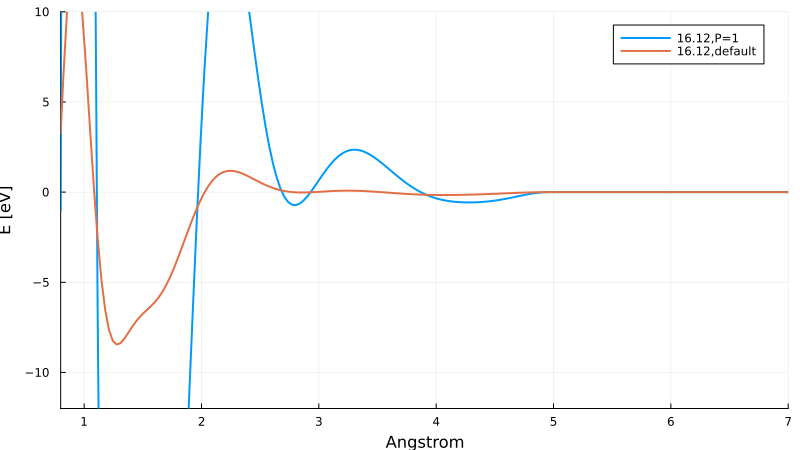

In [20]:
studylist = ["16.12,P=1","16.12,default"]

plt_dim = plot(
    legend = :topright, 
    xlabel = "Angstrom", ylabel = "E [eV]",
    xlims = (0.8, 7), ylims = (-12, 10),
    # xlims = (0.8, 7), ylims = (-0.5,0.5),
    size= (800,450))

for tag in studylist
    D = ACEpotentials.dimers(potlist[tag], [:C,],rr = range(0.529177, 7.0, length=200));
    plot!(plt_dim, D[(:C,:C)]..., lw=2, label = "$tag")
end

plt_dim

# Playground

In [17]:
@doc ACE1x.mb_ace_basis

No documentation found.

`ACE1x.mb_ace_basis` is a `Function`.

```
# 1 method for generic function "mb_ace_basis" from ACE1x:
 [1] mb_ace_basis(kwargs)
     @ ~/.julia/packages/ACE1x/8w1lo/src/defaults.jl:319
```


In [14]:
basis_bin = Dict()
orders = [2,2,3,4]
degrees = [[10,3],[24,20],[24,20,16],[24,20,16,12]]
basis_tags = ["10.3","24.20","24.20.16","24.20.16.12"]


for (i,ord) in enumerate(orders)
    basis = ACE1x.ace_basis(
        elements = [:C],
        order = ord,
        totaldegree = degrees[i],
        # totaldegree = 20,
        rcut = 6.0,
        r0 = 1.0,
        pure = true)
    basis_bin[basis_tags[i]] = basis
    println("basis_bin[\"" * basis_tags[i] * "\"]")
    println(length(basis))
end


[ Info: Option `pure = true` overrides `pure2b=true`


basis_bin["10.3"]
12


[ Info: Option `pure = true` overrides `pure2b=true`


basis_bin["24.20"]
297


[ Info: Option `pure = true` overrides `pure2b=true`


basis_bin["24.20.16"]
802


[ Info: Option `pure = true` overrides `pure2b=true`


basis_bin["24.20.16.12"]
929


In [13]:
basis_bin["10.3"]

JuLIP.MLIPs.IPSuperBasis{JuLIP.MLIPs.IPBasis}(JuLIP.MLIPs.IPBasis[PolyPairBasis{ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{Float64}}, 1}(JuLIP.Potentials.SZList{1}(AtomicNumber[<6>]), ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{Float64}}[ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{Float64}}(ACE1.OrthPolys.OrthPolyBasis{Float64}(0, 0.37481910274963826, 0, 1.0, [0.9999999999999998, 5.5409616039541545, 6.194992696084185, 6.308687540580393, 6.348016603591635, 6.3661566056093255, 6.376008421563429, 6.381961829718582, 6.385843887927936, 6.388525572895417], [0.0, -3.8089099303592224, -4.258497149985512, -4.336652072034279, -4.363687245594827, -4.376156856243751, -4.3829290886289805, -4.38702151825807

In [30]:
using LinearAlgebra

In [31]:
a = [1, 2, 3]
b = [4, 5, 6]
c = range(0,8)
c_mat = reshape(collect(c), 3, 3)


3×3 Matrix{Int64}:
 0  3  6
 1  4  7
 2  5  8

In [ ]:
transpose(b) * a

32

In [11]:
show(stdout, "text/plain", basis_bin["10.5"])

JuLIP.MLIPs.IPSuperBasis{JuLIP.MLIPs.IPBasis}(JuLIP.MLIPs.IPBasis[PolyPairBasis{ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{Float64}}, 1}(JuLIP.Potentials.SZList{1}(AtomicNumber[<6>]), ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{Float64}}[ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{Float64}}(ACE1.OrthPolys.OrthPolyBasis{Float64}(0, 0.37481910274963826, 0, 1.0, [0.9999999999999998, 5.5409616039541545, 6.194992696084185, 6.308687540580393, 6.348016603591635, 6.3661566056093255, 6.376008421563429, 6.381961829718582, 6.385843887927936, 6.388525572895417], [0.0, -3.8089099303592224, -4.258497149985512, -4.336652072034279, -4.363687245594827, -4.376156856243751, -4.3829290886289805, -4.38702151825807

In [7]:
ACE1.get_nl(basis_bin["10.5"])

LoadError: MethodError: no method matching get_nl(::JuLIP.MLIPs.IPSuperBasis{JuLIP.MLIPs.IPBasis})

[0mClosest candidates are:
[0m  get_nl([91m::RPIBasis[39m, [91m::Any[39m)
[0m[90m   @[39m [35mACE1[39m [90m~/.julia/packages/ACE1/UJw9H/src/rpi/[39m[90m[4mrpi_basis.jl:70[24m[39m
[0m  get_nl([91m::RPIBasis[39m)
[0m[90m   @[39m [35mACE1[39m [90m~/.julia/packages/ACE1/UJw9H/src/rpi/[39m[90m[4mrpi_basis.jl:70[24m[39m


# Trial dim

In [ ]:
# dataset 
data_file = "/leonardo_work/Sis25_degironc_0/Tr124_dim.xyz"
data = read_extxyz(data_file);

LoadError: file /leonardo_work/Sis25_degironc_0/apol/Tr124_dim.xyz cannot be opened for reading

In [ ]:
# basis construction with purification (pure = true) or otherwise
r0 = 1.5
basis = ACE1x.ace_basis(
    elements = [:C],
    order = 2,
    totaldegree = 10,
    rcut = 7.0,
    r0 = r0,
    pure = true
)
@show length(basis)

LoadError: InterruptException:

In [ ]:
Vref = OneBody(:C => -245.44385736)

# regression weights
# weights = Dict(
#     "FLD_TiAl" => Dict("E" => 60.0, "F" => 1.0, "V" => 1.0 ),
#     "TiAl_T5000" => Dict("E" => 5.0, "F" => 1.0, "V" => 1.0)
# )
weights = Dict(
    "shaiducarbon" => Dict("E" => 1.85, "F" => 1.0)
    
)

Dict{String, Dict{String, Float64}} with 1 entry:
  "shaiducarbon" => Dict("E"=>1.85, "F"=>1.0)

In [ ]:
# Basis precomputation 
datakeys = (energy_key = "energy", force_key = "force")
train = [ACEpotentials.AtomsData(t; weights=weights, v_ref=Vref, datakeys...) for t in data]
A, Y, W = ACEfit.assemble(train, basis) # A, Y, W are needed for the solver. See equation below.
P = smoothness_prior(basis; p=4);

[ Info: Assembling linear problem.
[ Info:   - Creating feature matrix with size (854, 51).
[ Info:   - Beginning assembly with processor count:  1.
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48
[ Info:   - Assembly completed.
[ Info: Assembling full weight vector.
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [ ]:
# Potential 1
solver = ACEfit.LSQR(damp = 1e-2, atol = 1e-6, P = P) # damp = lambda 
results = ACEfit.solve(solver, W .* A, W .* Y) # W .* A is element-wise multiplication of W and A
pot_1 = JuLIP.MLIPs.SumIP(Vref, JuLIP.MLIPs.combine(basis, results["C"]))

damp  0.01
atol  1.0e-6
maxiter  100000
Converged

┌ Warning: Need to apply preconditioner in LSQR.
└ @ ACEfit ~/.julia/packages/ACEfit/IW8vD/src/solvers.jl:95


 after 18 iterations.
relative RMS error  0.017411714536787613


JuLIP.MLIPs.SumIP{Any}(Any[OneBody{Float64}(Dict(:C => -245.44385736)), PolyPairPot{Float64, ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{Float64}}, 1, 0}([60.82150888596024, -107.76630728966568, 128.99107446918865, -122.53761941275778, 114.52399175351684, -93.21677276107971, 68.63941707379006, -41.29809623508968, 18.542051584709743, -4.866236628908764], PolyPairBasis{ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{Float64}}, 1}(JuLIP.Potentials.SZList{1}(AtomicNumber[<6>]), ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{Float64}}[ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{Float64}}(ACE1.OrthPolys.OrthPo

In [ ]:
# Potential 2 to highlight advantage of acebasis
weights["shaiducarbon"]["E"] = 500.0
W = ACEfit.assemble_weights(train)
solver = ACEfit.LSQR(damp = 1e-2, atol = 1e-6, P = P)
results = ACEfit.solve(solver, W .* A, W .* Y)
pot_2 = JuLIP.MLIPs.SumIP(Vref, JuLIP.MLIPs.combine(basis, results["C"]))

damp  0.01
atol  1.0e-6
maxiter  100000
Converged after 18 iterations.
relative RMS error  0.0056854398156393595


[ Info: Assembling full weight vector.
┌ Warning: Need to apply preconditioner in LSQR.
└ @ ACEfit ~/.julia/packages/ACEfit/IW8vD/src/solvers.jl:95


JuLIP.MLIPs.SumIP{Any}(Any[OneBody{Float64}(Dict(:C => -245.44385736)), PolyPairPot{Float64, ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{Float64}}, 1, 0}([9.56929033776388, -23.73847099226515, 31.86488251807065, -24.94701030245997, 25.92934690735256, -20.180142314604314, 15.583558325293476, -9.320807614255388, 4.524725230817843, -1.4746101217923413], PolyPairBasis{ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{Float64}}, 1}(JuLIP.Potentials.SZList{1}(AtomicNumber[<6>]), ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{Float64}}[ACE1.OrthPolys.TransformedPolys{Float64, ACE1.Transforms.Agnesi2Transform{Float64, Int64}, ACE1.OrthPolys.OrthPolyBasis{Float64}, PolyEnvelope{Float64}}(ACE1.OrthPolys.OrthPolyB

# Validation/testing

In [ ]:
test_data_dir = "/leonardo_work/Sis25_degironc_0/apol/Val123_dim.xyz"
test_data = read_extxyz(test_data_dir);

In [ ]:
test = [ACEpotentials.AtomsData(t; weights=weights, v_ref=Vref, datakeys...) for t in test_data]

@info("Test Error Tables")
@info("First Potential")
err1 = ACEpotentials.linear_errors(train, pot_1);

[ Info: Test Error Tables
[ Info: First Potential
[ Info: RMSE Table


┌──────────────┬─────────┬──────────┬─────────┐
│         Type │ E [meV] │ F [eV/A] │ V [meV] │
├──────────────┼─────────┼──────────┼─────────┤
│ shaiducarbon │ 165.288 │    1.470 │   0.000 │
├──────────────┼─────────┼──────────┼─────────┤
│          set │ 165.288 │    1.470 │   0.000 │
└──────────────┴─────────┴──────────┴─────────┘
┌──────────────┬─────────┬──────────┬─────────┐
│         Type │ E [meV] │ F [eV/A] │ V [meV] │
├──────────────┼─────────┼──────────┼─────────┤
│ shaiducarbon │ 139.360 │    1.109 │   0.000 │
├──────────────┼─────────┼──────────┼─────────┤
│          set │ 139.360 │    1.109 │   0.000 │
└──────────────┴─────────┴──────────┴─────────┘


[ Info: MAE Table


In [ ]:
err1["rmse"]["shaiducarbon"]["F"]

1.4698637181764689

In [ ]:
err1["rmse"]

Dict{String, Any} with 2 entries:
  "set"          => Dict("V"=>0.0, "E"=>0.165288, "F"=>1.46986)
  "shaiducarbon" => Dict("V"=>0.0, "E"=>0.165288, "F"=>1.46986)

In [ ]:
typeof(err1["rmse"])

Dict{String, Any}

In [ ]:
save_dict("err1.json",err1["rmse"])

In [ ]:
qwer = load_dict("err1.json")
print(qwer,"\n", typeof(qwer))

Dict{String, Any}("set" => Dict{String, Any}("V" => 0.0, "E" => 0.165287944228281, "F" => 1.4698637181764689), "shaiducarbon" => Dict{String, Any}("V" => 0.0, "E" => 0.165287944228281, "F" => 1.4698637181764689))
Dict{String, Any}

In [ ]:
@info("Second Potential:")
ACEpotentials.linear_errors(train, pot_2);

┌──────────────┬─────────┬──────────┬─────────┐
│         Type │ E [meV] │ F [eV/A] │ V [meV] │
├──────────────┼─────────┼──────────┼─────────┤
│ shaiducarbon │  66.950 │    2.744 │   0.000 │
├──────────────┼─────────┼──────────┼─────────┤
│          set │  66.950 │    2.744 │   0.000 │
└──────────────┴─────────┴──────────┴─────────┘
┌──────────────┬─────────┬──────────┬─────────┐
│         Type │ E [meV] │ F [eV/A] │ V [meV] │
├──────────────┼─────────┼──────────┼─────────┤
│ shaiducarbon │  50.192 │    1.064 │   0.000 │
├──────────────┼─────────┼──────────┼─────────┤
│          set │  50.192 │    1.064 │   0.000 │
└──────────────┴─────────┴──────────┴─────────┘


[ Info: Second Potential:
[ Info: RMSE Table
[ Info: MAE Table


# Dimers

In [2]:
using Plots, LaTeXStrings, DelimitedFiles

In [3]:
pwd()

"/leonardo_work/Sis25_degironc_0/apol/aceconverge2025"

In [4]:
## Basis check 
# basisvals = ["10.5", "40.10", "46.16", "40.10.9", "46.16.12", "46.20.14", "46.24.16", "40.10.9.8", "46.20.14.10"]
# basisvals = ["16.12","46.16","16.12.8","46.16.12","46.20.14","16.12.8.4"]
basisvals = ["24.20", "24.20.16"]
ecostvals = ["10.0"]
dset = "Tr1k_dia"
# basisvals = ["16.12.8","46.20.14"]
# basisvals = ["40.10.9"]
pots_bybasis = Dict()
# pots_bybasis_si = Dict()
for basis in basisvals
    for ecost in ecostvals
        println("Loading potential for basis $basis with ecost $ecost")
        pots_bybasis["$basis,ecost=$ecost"] = load_potential("acejulia/$(dset)_purify/$basis/ecost$ecost/potential.json");
        # pots_bybasis_si["$basis,ecost=$ecost"] = load_potential("acejulia/Tr1k_n/$basis/ecost$ecost/potential.json");
    end
end


Loading potential for basis 24.20 with ecost 10.0

This potential was saved with following versions:

JuLIP v0.14.8
ACEbase v0.4.4
ACE1x v0.1.11
ACE1 v0.12.5
ACEmd v0.1.17
ACEpotentials v0.6.7
ACEfit v0.1.5

If you have problems with using this potential, pin your installation to above versions.

Loading potential for basis 24.20.16 with ecost 10.0

This potential was saved with following versions:

JuLIP v0.14.8
ACEbase v0.4.4
ACE1x v0.1.11
ACE1 v0.12.5
ACEmd v0.1.17
ACEpotentials v0.6.7
ACEfit v0.1.5

If you have problems with using this potential, pin your installation to above versions.



In [5]:
pots_bybasis

Dict{Any, Any} with 2 entries:
  "24.20.16,ecost=10.0" => SumIP{AbstractCalculator}(AbstractCalculator[OneBody…
  "24.20,ecost=10.0"    => SumIP{AbstractCalculator}(AbstractCalculator[OneBody…

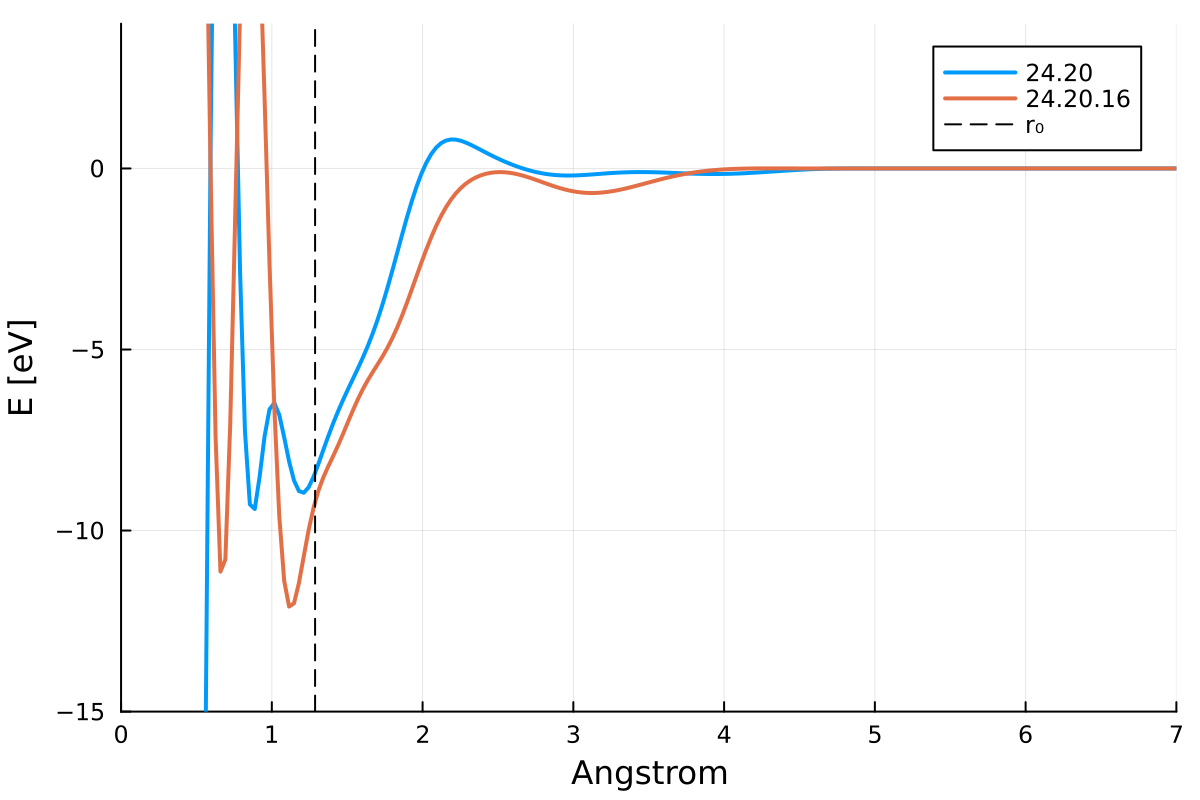

In [7]:
## Tolerance check

plt_dim = plot(
    legend = :topright, 
    xlabel = "Angstrom", ylabel = "E [eV]",
    xlims = (0, 7), ylims = (-15, 4),
    dpi=200)

for tag in basisvals
    D = ACEpotentials.dimers(pots_bybasis[tag * ",ecost=10.0"], [:C,], rr = range(0.529177, 7.0, length=200))
    # Dsi = ACEpotentials.dimers(pots_bybasis_si[tag * ",ecost=5.0"], [:C,], rr = range(0.529177, 7.0, length=200))
    plot!(plt_dim, D[(:C,:C)]..., lw=2, label = "$tag")
    # plot!(plt_dim, Dsi[(:C,:C)]..., lw=2, linestyle=:dash, label = "$tag (self-int)")
end
vline!(plt_dim, [1.286958464], linestyle=:dash, color=:black, label="r₀")
plt_dim

In [ ]:
save_potential("/leonardo_work/Sis25_degironc_0/apol/aceconverge2025/acejulia/test_pot.json", pot_1)